In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler, RobustScaler
from collections import Counter
import pandas as pd
from scipy.io import loadmat

In [2]:
m = loadmat("dato_taller.mat", squeeze_me=True, struct_as_record=False)
X_train = np.asarray(m["x_entena"], dtype=np.float32)
X_test  = np.asarray(m["x_prueba"],  dtype=np.float32)
y_train = np.asarray(m["y_entrena"]).reshape(-1).astype(np.int64)

In [17]:
# Usaremos el conjunto de entrenamiento como base del análisis
X = np.asarray(X_train, dtype=np.float64)
y = np.asarray(y_train)


In [18]:
print("X shape:", X.shape, "dtype:", X.dtype)
print("y shape:", y.shape, "clases:", np.unique(y).size)

X shape: (1000, 20) dtype: float64
y shape: (1000,) clases: 2


In [19]:
# NaN / Inf
n_nans = np.isnan(X).sum()
n_infs = np.isinf(X).sum()
print(f"NaNs totales: {n_nans} | Infs totales: {n_infs}")

NaNs totales: 0 | Infs totales: 0


In [20]:
# Duplicados exactos
dfX = pd.DataFrame(X)
dup_mask = dfX.duplicated()
print("Filas duplicadas:", int(dup_mask.sum()))

Filas duplicadas: 0


In [21]:
# Varianza por columna (candidatas a eliminar si var=0)
var = dfX.var(axis=0)
zero_var_cols = var.index[var == 0].tolist()
print("Features con varianza 0:", zero_var_cols)

Features con varianza 0: []


In [22]:
# Señal simple de outliers por IQR (por feature y por fila)
Q1 = dfX.quantile(0.25); Q3 = dfX.quantile(0.75); IQR = Q3 - Q1
outlier_mask = ((dfX < (Q1 - 1.5*IQR)) | (dfX > (Q3 + 1.5*IQR)))
print("Porcentaje de filas con algún outlier (IQR):", round(100*outlier_mask.any(axis=1).mean(), 2), "%")


Porcentaje de filas con algún outlier (IQR): 10.4 %


In [23]:
# Distribución de clases (si hay etiquetas)
print("Distribución y:", Counter(y))

Distribución y: Counter({1: 531, -1: 469})


In [40]:
apply_drop_duplicates = False
apply_impute_missing = False  # cambia a True si viste NaNs
apply_drop_zero_var = True if 'zero_var_cols' in globals() and len(zero_var_cols) > 0 else False

dfX_clean = dfX.copy()
y_clean = y.copy()

if apply_drop_duplicates:
    keep_mask = ~dfX_clean.duplicated()
    dfX_clean = dfX_clean.loc[keep_mask].reset_index(drop=True)
    y_clean = y_clean[keep_mask.values]

if apply_impute_missing:
    imp = SimpleImputer(strategy="median")
    dfX_clean = pd.DataFrame(imp.fit_transform(dfX_clean), columns=dfX_clean.columns)

if apply_drop_zero_var:
    dfX_clean = dfX_clean.drop(columns=zero_var_cols)

X_clean = dfX_clean.to_numpy(dtype=np.float64)
print("X_clean shape:", X_clean.shape)

X_clean shape: (1000, 20)


In [41]:
# Pipeline base: escalado + PCA para clustering; PCA 2D para visualización
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

use_robust = False  # cambia a True si hay muchos outliers segun auditoría

X_base = X_clean if 'X_clean' in globals() else X
scaler = RobustScaler() if use_robust else StandardScaler()
X_scaled_train = scaler.fit_transform(X_base)

# PCA para clustering: conserva ~95% de varianza
pca_rep = PCA(n_components=0.95, random_state=42)
X_rep_train = pca_rep.fit_transform(X_scaled_train)
print("Dim. representación:", X_rep_train.shape[1], "| Varianza:", round(pca_rep.explained_variance_ratio_.sum(), 3))

# PCA 2D solo para plots
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_scaled_train)

# Re-etiquetar y en 0..K-1 (si las etiquetas no están así)
classes = np.unique(y if 'y_clean' not in globals() else y_clean)
y_map = {c:i for i,c in enumerate(classes)}
y_work = np.vectorize(y_map.get)(y if 'y_clean' not in globals() else y_clean)

# Utilidad para transformar nuevos datos con el pipeline (p.ej. X_test)
def transform_for_clustering(X_new):
    Xs = scaler.transform(np.asarray(X_new, dtype=np.float64))
    return pca_rep.transform(Xs)

# Transformar test si está disponible
if 'X_test' in globals():
    X_scaled_test = scaler.transform(np.asarray(X_test, dtype=np.float64))
    X_rep_test = pca_rep.transform(X_scaled_test)
    print("Test transformado:", X_rep_test.shape)


Dim. representación: 19 | Varianza: 0.969
Test transformado: (10000, 19)


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from sklearn.metrics import (
    silhouette_score, silhouette_samples,
    calinski_harabasz_score, davies_bouldin_score,
    adjusted_rand_score, normalized_mutual_info_score
)

def eval_clustering(X, labels, y_true=None, name=None, ignore_noise=True):
    labels = np.asarray(labels)
    out = {}
    mask = np.ones(len(labels), dtype=bool)
    if ignore_noise and np.any(labels == -1):
        mask = labels != -1
    if np.sum(mask) > 1 and len(np.unique(labels[mask])) >= 2:
        out['silhouette'] = silhouette_score(X[mask], labels[mask])
        out['calinski'] = calinski_harabasz_score(X[mask], labels[mask])
        out['davies'] = davies_bouldin_score(X[mask], labels[mask])
    else:
        out['silhouette'] = np.nan
        out['calinski'] = np.nan
        out['davies'] = np.nan
    out['n_clusters'] = len(set(labels)) - (1 if -1 in labels else 0)
    out['noise_frac'] = float(np.mean(labels == -1)) if np.any(labels == -1) else 0.0
    if y_true is not None:
        out['ARI'] = adjusted_rand_score(y_true, labels)
        out['NMI'] = normalized_mutual_info_score(y_true, labels)
    if name:
        out['model'] = name
    return out

def plot_silhouette(X, labels, title='Silhouette por cluster'):
    labels = np.asarray(labels)
    mask = labels != -1
    if np.sum(mask) <= 1 or len(np.unique(labels[mask])) < 2:
        print('No hay >=2 clusters válidos para silhouette')
        return
    s = silhouette_samples(X[mask], labels[mask])
    y_lower = 10
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    for c in sorted(np.unique(labels[mask])):
        vals = np.sort(s[labels[mask]==c])
        size = len(vals)
        y_upper = y_lower + size
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, vals, alpha=0.6)
        ax.text(-0.05, y_lower + 0.5*size, str(c))
        y_lower = y_upper + 10
    ax.set_title(title)
    ax.set_xlabel('Silhouette')
    ax.axvline(np.mean(s), color='red', linestyle='--')
    plt.tight_layout()

,silhouette,calinski,davies,n_clusters,noise_frac,ARI,NMI,model
0,0.095906,113.394823,2.928134,2,0.0,-0.000982,0.000011,KMeans2
1,0.084216,96.967061,2.620368,3,0.0,0.077936,0.076292,KMeans3
2,0.073012,83.346466,2.843155,4,0.0,0.227610,0.244413,KMeans4
3,0.062508,68.192127,3.170587,5,0.0,0.187679,0.219433,KMeans5
4,0.056885,58.398601,3.331559,6,0.0,0.157828,0.195925,KMeans6
5,0.047098,51.600547,3.624617,7,0.0,0.129098,0.188971,KMeans7
6,0.043612,46.708760,3.727950,8,0.0,0.115410,0.184298,KMeans8
7,0.049213,42.989945,3.350304,9,0.0,0.107856,0.156806,KMeans9
8,0.045366,39.908252,3.478709,10,0.0,0.089307,0.159945,KMeans10


Mejor k por silhouette: 2 score= 0.096


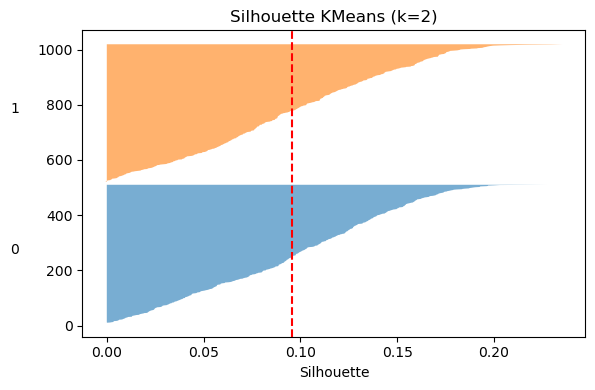

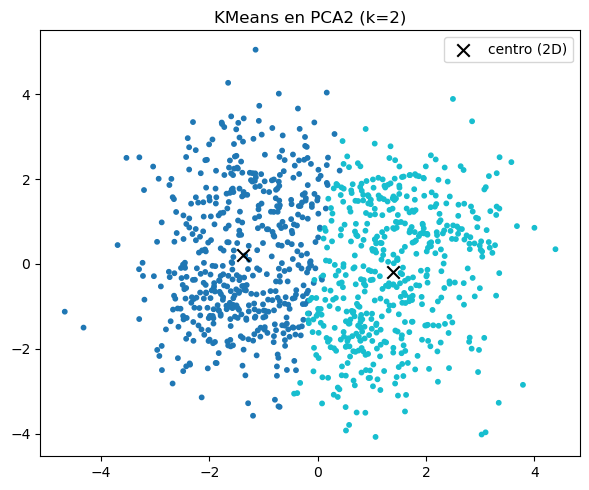

In [43]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

Ks = range(2, 11)
metrics = []
best_s, best_k = -1, None

for k in Ks:
    km = KMeans(n_clusters=k, n_init=50, random_state=42)
    labels = km.fit_predict(X_rep_train)
    m = eval_clustering(X_rep_train, labels, y_true=(y_work if 'y_work' in globals() else None),
                        name=f'KMeans{k}', ignore_noise=False)
    metrics.append(m)
    if not np.isnan(m['silhouette']) and m['silhouette'] > best_s:
        best_s, best_k, best_labels, best_model = m['silhouette'], k, labels, km

km_results_df = pd.DataFrame(metrics)
display(km_results_df)
print('Mejor k por silhouette:', best_k, 'score=', round(best_s,3))

# Silhouette por cluster
plot_silhouette(X_rep_train, best_labels, title=f'Silhouette KMeans (k={best_k})')

# Visualización PCA2 con centros aproximados (media de puntos por cluster en 2D)
centers_2d = np.vstack([X_pca2[best_labels==c].mean(axis=0) for c in sorted(np.unique(best_labels))])
plt.figure(figsize=(6,5))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=best_labels, s=10, cmap='tab10')
plt.scatter(centers_2d[:,0], centers_2d[:,1], c='black', s=80, marker='x', label='centro (2D)')
plt.legend(); plt.title(f'KMeans en PCA2 (k={best_k})')
plt.tight_layout(); plt.show()


Coeficiente cophenético (ward, muestra): 0.337


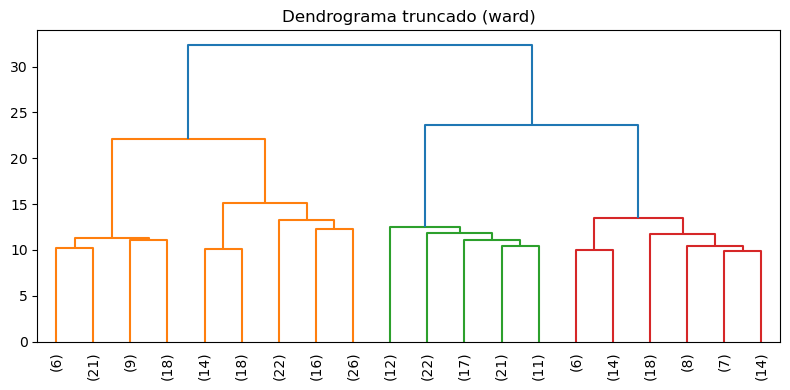

Resultados por linkage:
  ward: k*=2, silhouette=0.081
  complete: k*=2, silhouette=0.047
  average: k*=2, silhouette=0.194
  single: k*=2, silhouette=0.201


,silhouette,calinski,davies,n_clusters,noise_frac,ARI,NMI,model
0,0.080515,93.981728,3.205866,2,0.0,0.001294,0.002001,ward-2
1,0.059089,73.162229,3.094678,3,0.0,0.040053,0.045099,ward-3
2,0.049219,65.249480,3.217438,4,0.0,0.116546,0.124691,ward-4
3,0.033822,52.651496,3.818926,5,0.0,0.111910,0.115654,ward-5
4,0.031341,45.122673,3.621484,6,0.0,0.107488,0.112143,ward-6
5,0.031022,39.931355,3.605633,7,0.0,0.100068,0.107415,ward-7
6,0.029313,36.045948,3.696318,8,0.0,0.099784,0.109102,ward-8
7,0.018808,33.132529,3.982787,9,0.0,0.073043,0.102511,ward-9
8,0.014359,30.803481,3.843553,10,0.0,0.072874,0.100010,ward-10
9,0.047424,54.801958,4.046303,2,0.0,0.002907,0.001820,complete-2


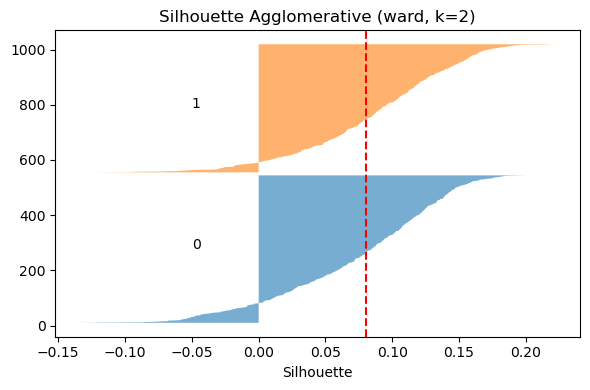

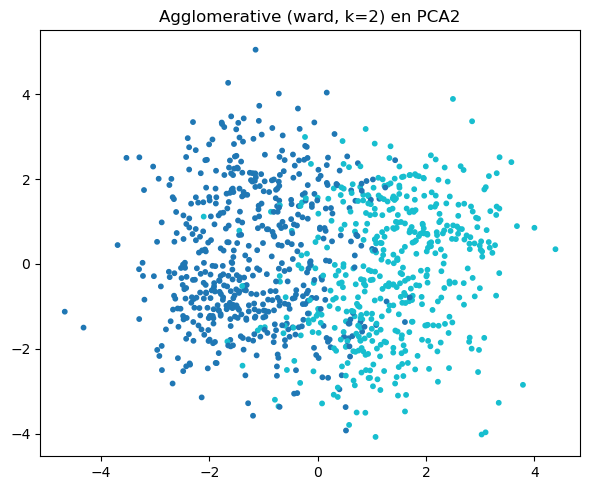

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering

# Dendrograma (muestra para no saturar gráficos)
rng = np.random.RandomState(42)
idx = rng.choice(X_rep_train.shape[0], size=min(300, X_rep_train.shape[0]), replace=False)
Z = linkage(X_rep_train[idx], method='ward')
coph, _ = cophenet(Z, pdist(X_rep_train[idx]))
print('Coeficiente cophenético (ward, muestra):', round(coph,3))

plt.figure(figsize=(8,4))
dendrogram(Z, p=20, truncate_mode='lastp', leaf_rotation=90, leaf_font_size=10)
plt.title('Dendrograma truncado (ward)'); plt.tight_layout(); plt.show()

# Evaluación de varios linkages y k
def fit_agglom(method, k):
    try:
        return AgglomerativeClustering(n_clusters=k, linkage=method, metric='euclidean')
    except TypeError:
        return AgglomerativeClustering(n_clusters=k, linkage=method, affinity='euclidean')

agg_results = []
best = {}
for method in ['ward', 'complete', 'average', 'single']:
    scores=[]
    for k in range(2, 11):
        model = fit_agglom(method, k)
        labels = model.fit_predict(X_rep_train)
        m = eval_clustering(X_rep_train, labels, y_true=(y_work if 'y_work' in globals() else None),
                            name=f'{method}-{k}', ignore_noise=False)
        agg_results.append(m)
        scores.append((k, m['silhouette'], labels))
    k_star, s_star, labels_star = max(scores, key=lambda t: (t[1] if not np.isnan(t[1]) else -1))
    best[method] = (k_star, s_star, labels_star)

print('Resultados por linkage:')
for method,(k_star, s_star, _) in best.items():
    print(f'  {method}: k*={k_star}, silhouette={s_star:.3f}')

agg_results_df = pd.DataFrame(agg_results)
display(agg_results_df)

# Visualizar mejor ward por defecto
k_star, s_star, labels_star = best['ward']
plot_silhouette(X_rep_train, labels_star, title=f'Silhouette Agglomerative (ward, k={k_star})')

plt.figure(figsize=(6,5))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels_star, s=10, cmap='tab10')
plt.title(f'Agglomerative (ward, k={k_star}) en PCA2')
plt.tight_layout(); plt.show()


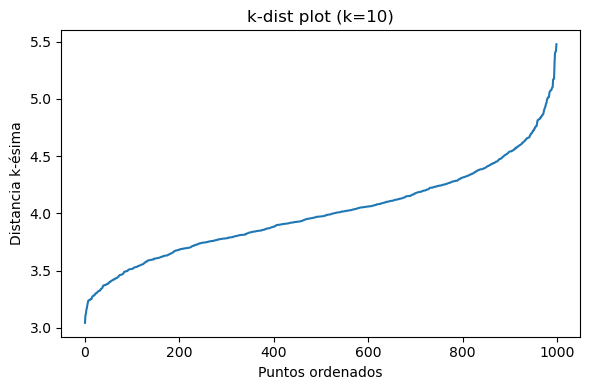

,silhouette,calinski,davies,n_clusters,noise_frac,ARI,NMI,model
0,NaN,NaN,NaN,1,0.043,0.007466,0.016198,DBSCAN eps=4.165 ms=5
1,NaN,NaN,NaN,1,0.026,0.004561,0.012371,DBSCAN eps=4.288 ms=5
2,NaN,NaN,NaN,1,0.010,0.000627,0.000932,DBSCAN eps=4.465 ms=5
3,NaN,NaN,NaN,1,0.003,-0.000211,0.000320,DBSCAN eps=4.748 ms=5
4,NaN,NaN,NaN,1,0.016,0.001818,0.004090,DBSCAN eps=4.402 ms=10
5,NaN,NaN,NaN,1,0.007,0.000332,0.000405,DBSCAN eps=4.539 ms=10
6,NaN,NaN,NaN,1,0.003,-0.000211,0.000320,DBSCAN eps=4.723 ms=10
7,NaN,NaN,NaN,1,0.001,-0.000234,0.001812,DBSCAN eps=4.994 ms=10


No se encontraron parámetros DBSCAN con >=2 clusters útiles


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# k-dist plot (k ~ min_samples) para guiar eps
k_for_plot = 10
nn = NearestNeighbors(n_neighbors=k_for_plot).fit(X_rep_train)
distances, _ = nn.kneighbors(X_rep_train)
d_k = np.sort(distances[:, k_for_plot-1])

plt.figure(figsize=(6,4))
plt.plot(d_k)
plt.title(f'k-dist plot (k={k_for_plot})'); plt.xlabel('Puntos ordenados'); plt.ylabel('Distancia k-ésima')
plt.tight_layout(); plt.show()

# Búsqueda simple de hiperparámetros
min_samples_list = [5, 10, 15]
qs = [0.85, 0.90, 0.95, 0.98]

results=[]
best=None
best_score=-np.inf
for min_s in min_samples_list:
    nn = NearestNeighbors(n_neighbors=min_s).fit(X_rep_train)
    distances, _ = nn.kneighbors(X_rep_train)
    d_k = np.sort(distances[:, min_s-1])
    eps_list = list(np.quantile(d_k, qs))
    for eps in eps_list:
        db = DBSCAN(eps=float(eps), min_samples=int(min_s), metric='euclidean')
        labels = db.fit_predict(X_rep_train)
        m = eval_clustering(X_rep_train, labels, y_true=(y_work if 'y_work' in globals() else None),
                            name=f'DBSCAN eps={eps:.3f} ms={min_s}', ignore_noise=True)
        results.append(m)
        sc = m['silhouette']
        if not np.isnan(sc) and sc > best_score and m['n_clusters']>=2:
            best_score = sc; best = (eps, min_s, labels)

dbscan_results_df = pd.DataFrame(results).sort_values(['silhouette','n_clusters'], ascending=[False,False])
display(dbscan_results_df.head(8))

if best is not None:
    eps, min_s, labels = best
    print(f'Mejor DBSCAN: eps={eps:.3f}, min_samples={min_s}, silhouette={best_score:.3f}, '
          f'n_clusters={len(set(labels))-(1 if -1 in labels else 0)}, ruido={np.mean(labels==-1):.2%}')
    plot_silhouette(X_rep_train, labels, title=f'Silhouette DBSCAN (eps={eps:.3f}, ms={min_s})')

    plt.figure(figsize=(6,5))
    plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels, s=10, cmap='tab10')
    plt.title(f'DBSCAN en PCA2 (eps={eps:.3f}, ms={min_s})')
    plt.tight_layout(); plt.show()
else:
    print('No se encontraron parámetros DBSCAN con >=2 clusters útiles')



DBSCAN no produjo >=2 clusters útiles con los parámetros probados.


,model,n_clusters,silhouette,calinski,davies,ARI,NMI,noise_frac
0,KMeans2,2,0.095906,113.394823,2.928134,-0.000982,0.000011,0.0
1,single-2,2,0.201237,2.145957,0.673522,-0.000234,0.001812,0.0


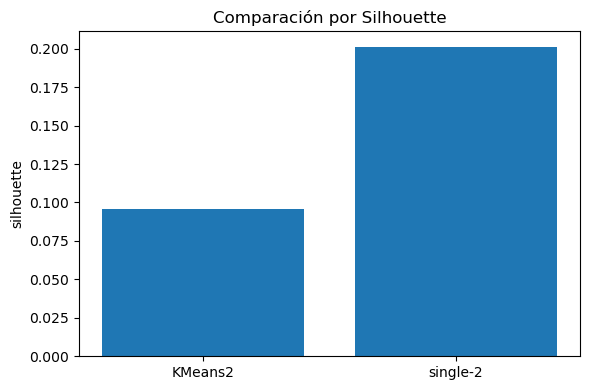

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

rows = []
cols = ['model','n_clusters','silhouette','calinski','davies','ARI','NMI','noise_frac']

if 'km_results_df' in globals() and not km_results_df.empty:
    row_km = km_results_df.loc[km_results_df['silhouette'].idxmax()]
    rows.append({c: row_km.get(c, np.nan) for c in cols})
else:
    print('km_results_df no disponible; ejecuta la celda de K-Means estudio.')

if 'agg_results_df' in globals() and not agg_results_df.empty:
    row_ag = agg_results_df.loc[agg_results_df['silhouette'].idxmax()]
    rows.append({c: row_ag.get(c, np.nan) for c in cols})
else:
    print('agg_results_df no disponible; ejecuta la celda de Jerárquico.')

if 'dbscan_results_df' in globals() and not dbscan_results_df.empty:
    dfdb = dbscan_results_df.copy()
    dfdb = dfdb[dfdb['n_clusters'] >= 2]
    if not dfdb.empty:
        row_db = dfdb.loc[dfdb['silhouette'].idxmax()]
        rows.append({c: row_db.get(c, np.nan) for c in cols})
    else:
        print('DBSCAN no produjo >=2 clusters útiles con los parámetros probados.')
else:
    print('dbscan_results_df no disponible; ejecuta la celda de DBSCAN.')

if rows:
    summary_df = pd.DataFrame(rows)
    display(summary_df)
    plt.figure(figsize=(6,4))
    plt.bar(summary_df['model'], summary_df['silhouette'])
    plt.title('Comparación por Silhouette')
    plt.ylabel('silhouette')
    plt.tight_layout(); plt.show()
else:
    print('No hay resultados para comparar aún.')


Elbow (kneedle) sugiere k=4 | Silhouette sugiere k=2


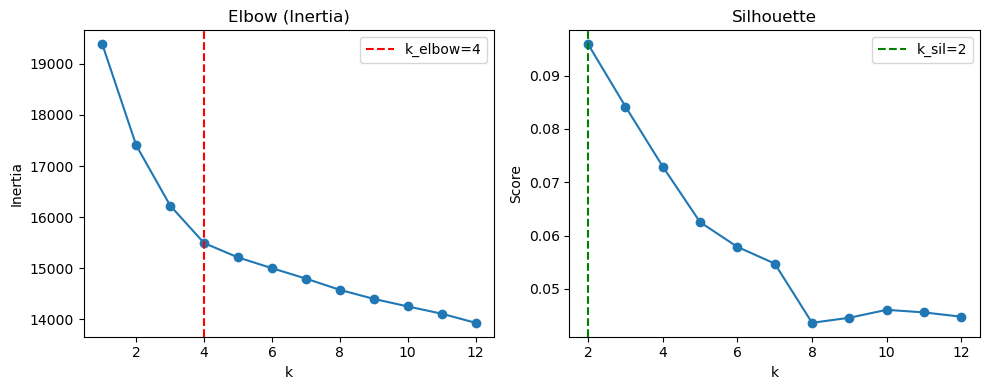

In [47]:
# Elbow (inercia) + detección de codo y comparación con silhouette
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Ks_inertia = range(1, 13)
inertias = []
for k in Ks_inertia:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    km.fit(X_rep_train)
    inertias.append(km.inertia_)

# Normalización y línea entre extremos para "Kneedle" (curva decreciente)
k_arr = np.array(list(Ks_inertia), dtype=float)
y_arr = np.array(inertias, dtype=float)
k_norm = (k_arr - k_arr.min()) / (k_arr.max() - k_arr.min() + 1e-12)
y_norm = (y_arr - y_arr.min()) / (y_arr.max() - y_arr.min() + 1e-12)
y_line = y_norm[0] + (y_norm[-1] - y_norm[0]) * (k_norm - k_norm[0]) / (k_norm[-1] - k_norm[0] + 1e-12)
diff = y_line - y_norm  # máximo => codo para curva decreciente
i_knee = int(np.argmax(diff))
k_elbow = int(k_arr[i_knee])

# Silhouette como referencia
Ks_sil = range(2, 13)
silh = []
for k in Ks_sil:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X_rep_train)
    silh.append(silhouette_score(X_rep_train, labels))
k_sil = int(Ks_sil[int(np.argmax(silh))])

# Ajuste si el elbow cae en 1
if k_elbow < 2:
    k_elbow = k_sil

print(f'Elbow (kneedle) sugiere k={k_elbow} | Silhouette sugiere k={k_sil}')

# Plots
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(list(Ks_inertia), inertias, marker='o')
ax[0].axvline(k_elbow, color='red', linestyle='--', label=f'k_elbow={k_elbow}')
ax[0].set_title('Elbow (Inertia)'); ax[0].set_xlabel('k'); ax[0].set_ylabel('Inertia'); ax[0].legend()
ax[1].plot(list(Ks_sil), silh, marker='o')
ax[1].axvline(k_sil, color='green', linestyle='--', label=f'k_sil={k_sil}')
ax[1].set_title('Silhouette'); ax[1].set_xlabel('k'); ax[1].set_ylabel('Score'); ax[1].legend()
plt.tight_layout(); plt.show()


{'silhouette': 0.07301230352325254, 'calinski': 83.34646640584342, 'davies': 2.843155036271164, 'n_clusters': 4, 'noise_frac': 0.0, 'ARI': 0.2276096389333248, 'NMI': 0.2444134230380909, 'model': 'KMeans(k=4)'}


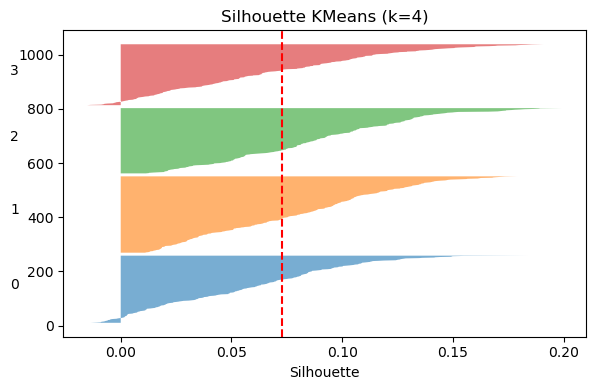

In [48]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

km_elbow = KMeans(n_clusters=int(k_elbow), n_init=50, random_state=42)
labels_km_elbow = km_elbow.fit_predict(X_rep_train)

km_cmp = eval_clustering(X_rep_train, labels_km_elbow, y_true=(y_work if 'y_work' in globals() else None),
                         name=f'KMeans(k={int(k_elbow)})', ignore_noise=False)
print(km_cmp)
plot_silhouette(X_rep_train, labels_km_elbow, title=f'Silhouette KMeans (k={int(k_elbow)})')


Mejor k (ward) por silhouette: 2
{'silhouette': 0.0805145514831502, 'calinski': 93.98172814535059, 'davies': 3.2058664436580626, 'n_clusters': 2, 'noise_frac': 0.0, 'ARI': 0.0012942058723526867, 'NMI': 0.002001387153854922, 'model': 'Agglomerative(ward,k=2)'}


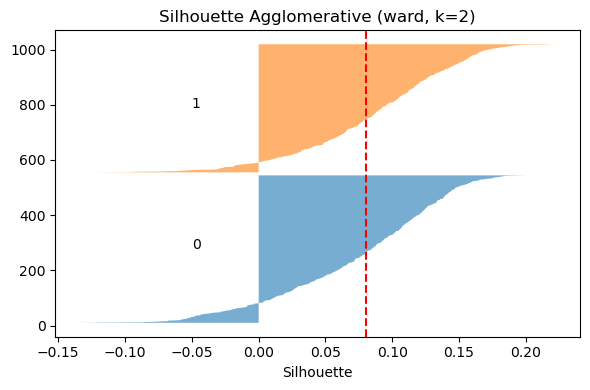

In [49]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

silh_scores = []
labels_by_k = {}
for k in range(2, 13):
    try:
        ag = AgglomerativeClustering(n_clusters=k, linkage='ward', metric='euclidean')
    except TypeError:
        ag = AgglomerativeClustering(n_clusters=k, linkage='ward', affinity='euclidean')
    labels = ag.fit_predict(X_rep_train)
    labels_by_k[k] = labels
    # silhouette requiere >=2 clusters
    silh_scores.append(silhouette_score(X_rep_train, labels))

k_ag = 2 + int(np.argmax(silh_scores))
labels_ag = labels_by_k[k_ag]

ag_cmp = eval_clustering(X_rep_train, labels_ag, y_true=(y_work if 'y_work' in globals() else None),
                         name=f'Agglomerative(ward,k={k_ag})', ignore_noise=False)
print('Mejor k (ward) por silhouette:', k_ag)
print(ag_cmp)
plot_silhouette(X_rep_train, labels_ag, title=f'Silhouette Agglomerative (ward, k={k_ag})')


In [50]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Si ya tienes "best" y "dbscan_results_df" de la celda anterior de DBSCAN, se reutilizan.
labels_db, eps_db, min_s_db = None, None, None

if 'best' in globals() and isinstance(best, tuple) and len(best) == 3:
    eps_db, min_s_db, labels_db = best[0], best[1], best[2]
else:
    # Búsqueda mínima y rápida
    min_samples_list = [10]
    qs = [0.90, 0.95]
    best_score = -np.inf
    best_local = None
    results = []
    for min_s in min_samples_list:
        nn = NearestNeighbors(n_neighbors=min_s).fit(X_rep_train)
        distances, _ = nn.kneighbors(X_rep_train)
        d_k = np.sort(distances[:, min_s-1])
        eps_list = list(np.quantile(d_k, qs))
        for eps in eps_list:
            db = DBSCAN(eps=float(eps), min_samples=int(min_s), metric='euclidean')
            labels = db.fit_predict(X_rep_train)
            m = eval_clustering(X_rep_train, labels, y_true=(y_work if 'y_work' in globals() else None),
                                name=f'DBSCAN eps={eps:.3f} ms={min_s}', ignore_noise=True)
            results.append(m)
            sc = m['silhouette']
            if not np.isnan(sc) and m['n_clusters'] >= 2 and sc > best_score:
                best_score = sc; best_local = (eps, min_s, labels)
    if best_local is not None:
        eps_db, min_s_db, labels_db = best_local
        dbscan_results_df = pd.DataFrame(results).sort_values(['silhouette','n_clusters'], ascending=[False,False])

if labels_db is None:
    print('DBSCAN no encontró >=2 clusters útiles con esta búsqueda rápida. Ajusta min_samples/eps.')
else:
    print(f'DBSCAN elegido: eps={eps_db:.3f}, min_samples={min_s_db}')


DBSCAN no encontró >=2 clusters útiles con esta búsqueda rápida. Ajusta min_samples/eps.


KMeans mapping (cluster->clase): {0: 0, 1: 1, 2: 2, 3: 3} | acc: 0.435


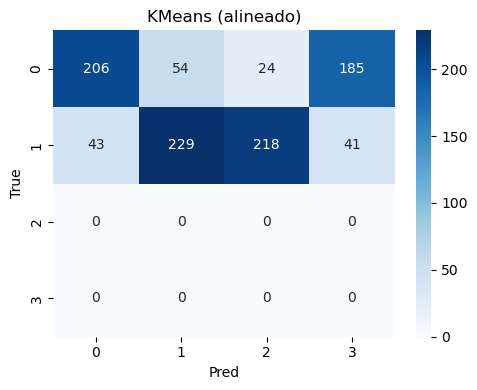

Agglomerative mapping (cluster->clase): {0: 0, 1: 1} | acc: 0.524


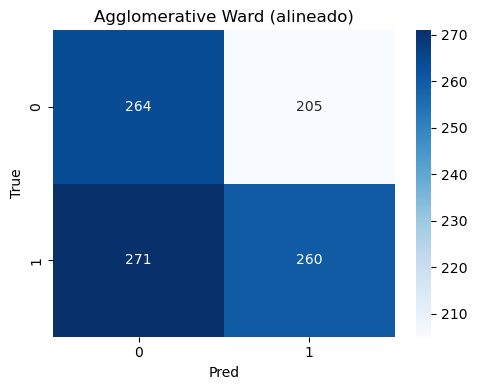

DBSCAN no disponible para matriz de confusión.


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment

def align_and_confusion(y_true, labels):
    y_true = np.asarray(y_true)
    labels = np.asarray(labels)
    cm = confusion_matrix(y_true, labels)
    r_ind, c_ind = linear_sum_assignment(-cm)  # maximiza la diagonal
    mapping = {c: r for r, c in zip(r_ind, c_ind)}
    labels_aligned = np.vectorize(lambda t: mapping.get(t, t))(labels)
    cm_aligned = confusion_matrix(y_true, labels_aligned)
    acc = np.trace(cm_aligned) / np.sum(cm_aligned)
    return labels_aligned, mapping, cm, cm_aligned, acc

def plot_cm(cm, title='Confusion matrix'):
    try:
        import seaborn as sns
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(title); plt.xlabel('Pred'); plt.ylabel('True'); plt.tight_layout(); plt.show()
    except Exception:
        plt.figure(figsize=(5,4))
        plt.imshow(cm, cmap='Blues'); plt.title(title); plt.xlabel('Pred'); plt.ylabel('True'); plt.colorbar(); plt.tight_layout(); plt.show()

# K-Means (k_elbow)
labels_km_aligned, map_km, cm_km_raw, cm_km, acc_km = align_and_confusion(y_work, labels_km_elbow)
print('KMeans mapping (cluster->clase):', map_km, '| acc:', round(acc_km,3))
plot_cm(cm_km, title='KMeans (alineado)')

# Jerárquico (ward)
labels_ag_aligned, map_ag, cm_ag_raw, cm_ag, acc_ag = align_and_confusion(y_work, labels_ag)
print('Agglomerative mapping (cluster->clase):', map_ag, '| acc:', round(acc_ag,3))
plot_cm(cm_ag, title='Agglomerative Ward (alineado)')

# DBSCAN (si existe)
if 'labels_db' in globals() and labels_db is not None:
    labels_db_aligned, map_db, cm_db_raw, cm_db, acc_db = align_and_confusion(y_work, labels_db)
    print('DBSCAN mapping (cluster->clase):', map_db, '| acc:', round(acc_db,3))
    plot_cm(cm_db, title='DBSCAN (alineado)')
else:
    acc_db = np.nan
    print('DBSCAN no disponible para matriz de confusión.')


,model,n_clusters,silhouette,calinski,davies,ARI,NMI,acc_aligned,noise_frac
0,KMeans(k=4),4,0.073012,83.346466,2.843155,0.227610,0.244413,0.435,0.0
1,"Agglomerative(ward,k=2)",2,0.080515,93.981728,3.205866,0.001294,0.002001,0.524,0.0


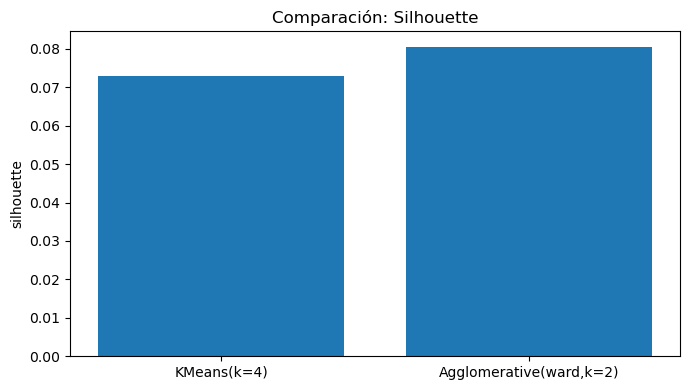

In [52]:
import pandas as pd
rows = []

# Recalcular métricas con etiquetas alineadas (solo para ARI/NMI importa la alineación, silhouette/calinski/davies usan labels tal cual)
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

km_cmp_final = eval_clustering(X_rep_train, labels_km_elbow, y_true=y_work, name=f'KMeans(k={int(k_elbow)})', ignore_noise=False)
km_cmp_final['acc_aligned'] = acc_km
rows.append(km_cmp_final)

ag_cmp_final = eval_clustering(X_rep_train, labels_ag, y_true=y_work, name=f'Agglomerative(ward,k={k_ag})', ignore_noise=False)
ag_cmp_final['acc_aligned'] = acc_ag
rows.append(ag_cmp_final)

if 'labels_db' in globals() and labels_db is not None:
    db_cmp_final = eval_clustering(X_rep_train, labels_db, y_true=y_work, name=f'DBSCAN(eps={eps_db:.3f},ms={min_s_db})', ignore_noise=True)
    db_cmp_final['acc_aligned'] = acc_db
    rows.append(db_cmp_final)

summary_df = pd.DataFrame(rows)[['model','n_clusters','silhouette','calinski','davies','ARI','NMI','acc_aligned','noise_frac']]
display(summary_df)

# Gráfico comparativo por silhouette
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.bar(summary_df['model'], summary_df['silhouette'])
plt.title('Comparación: Silhouette'); plt.ylabel('silhouette')
plt.tight_layout(); plt.show()


Centroides KMeans (escala original): shape (4, 20)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.483784,0.521537,-0.484131,0.571191,-0.335400,0.539597,-0.343380,0.434900,-0.533420,0.407660,-0.405218,0.457712,-0.516147,0.457223,-0.379716,0.567636,-0.390491,0.470304,-0.302671,0.539064
1,-0.383059,-0.388548,-0.379076,-0.393952,-0.562781,-0.425140,-0.441238,-0.405832,-0.381229,-0.457236,-0.490557,-0.429876,-0.517219,-0.555648,-0.398262,-0.389602,-0.479155,-0.460672,-0.351948,-0.418594
2,0.508210,0.608310,0.601203,0.461428,0.547663,0.560669,0.452260,0.646373,0.503526,0.344185,0.476263,0.637835,0.536686,0.402072,0.502661,0.581353,0.585198,0.395535,0.621276,0.412925
3,0.573814,-0.512219,0.290429,-0.539963,0.611166,-0.481785,0.535624,-0.618991,0.531509,-0.407987,0.580322,-0.434167,0.399968,-0.540449,0.468412,-0.559736,0.575847,-0.552764,0.529236,-0.500079


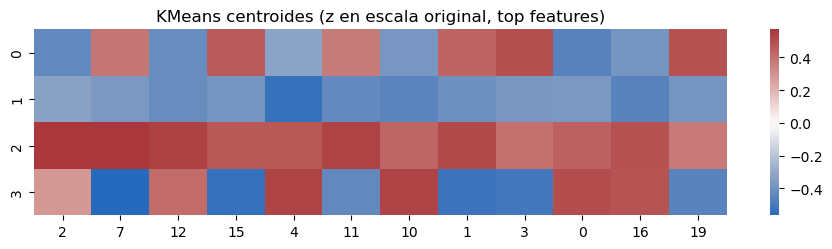

In [53]:
# Reconstrucción de centroides KMeans al espacio original (inversa de PCA y scaler)
# Requiere: km_elbow, pca_rep, scaler y que KMeans se ajustó sobre X_rep_train
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False

if 'km_elbow' in globals() and 'pca_rep' in globals() and 'scaler' in globals():
    centers_rep = km_elbow.cluster_centers_
    centers_std = pca_rep.inverse_transform(centers_rep)          # vuelve a espacio escalado
    centers_orig = scaler.inverse_transform(centers_std)          # vuelve a escala original

    # Marco con nombres de features
    if 'dfX_clean' in globals():
        feat_cols = dfX_clean.columns
    elif 'dfX' in globals():
        feat_cols = dfX.columns
    elif 'X_base' in globals():
        feat_cols = [f"f{i}" for i in range(X_base.shape[1])]
    else:
        feat_cols = [f"f{i}" for i in range(centers_orig.shape[1])]

    km_centers_df = pd.DataFrame(centers_orig, columns=feat_cols)
    print("Centroides KMeans (escala original): shape", km_centers_df.shape)
    display(km_centers_df.head())

    # Top features por desviación respecto a media global (escala original)
    if 'features_df' not in globals():
        # Reutiliza el df de G si no existe aún
        features_df = pd.DataFrame(X if 'X' in globals() else X_train, columns=feat_cols)
    gmean = features_df.mean(axis=0)
    gstd = features_df.std(axis=0).replace(0, 1e-9)
    km_centers_z = (km_centers_df - gmean) / gstd

    # Heatmap de top-N features por centroide
    top_n = 12
    max_abs = km_centers_z.abs().max(axis=0)
    top_feats = max_abs.sort_values(ascending=False).head(top_n).index
    data = km_centers_z.loc[:, top_feats]
    plt.figure(figsize=(min(12, 2+0.6*len(top_feats)), 1.2+0.35*len(km_centers_z)))
    if _HAS_SNS:
        sns.heatmap(data, center=0, cmap='vlag', annot=False)
    else:
        plt.imshow(data.values, aspect='auto', cmap='bwr', vmin=-np.max(np.abs(data.values)), vmax=np.max(np.abs(data.values)))
        plt.yticks(range(data.shape[0]), [f"c{i}" for i in range(data.shape[0])])
        plt.xticks(range(data.shape[1]), data.columns, rotation=90)
        plt.colorbar()
    plt.title("KMeans centroides (z en escala original, top features)")
    plt.tight_layout()
    plt.show()
else:
    print("Para reconstruir centroides necesitas km_elbow, pca_rep y scaler definidos (y KMeans ajustado sobre X_rep_train).")

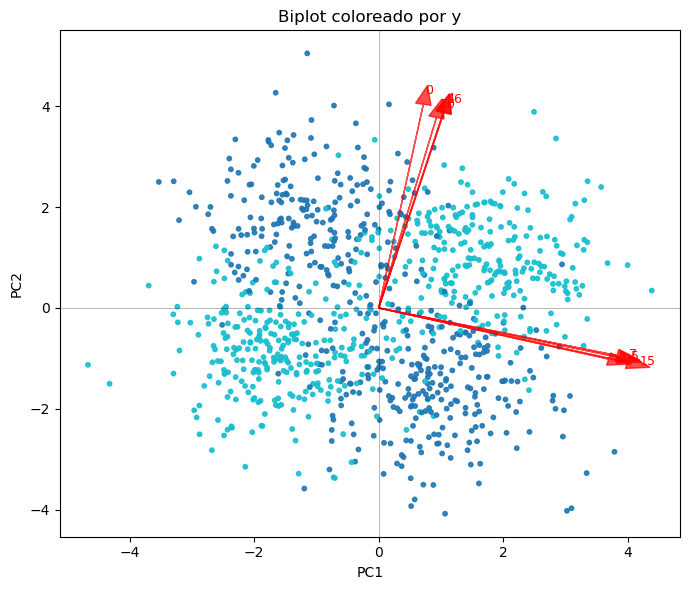

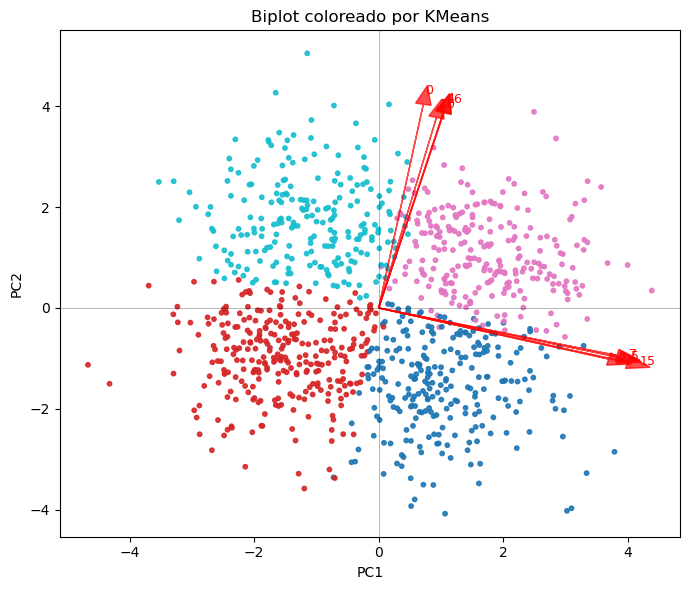

In [58]:
# PCA Biplot: puntos en PCA2 y vectores de features más influyentes
import numpy as np
import matplotlib.pyplot as plt

def pca_biplot(X2d, pca2, feature_names=None, color=None, title='PCA Biplot', top_n=8):
    # X2d: matriz (n,2) de PCA para puntos
    # pca2: objeto PCA(n_components=2) ya ajustado
    # feature_names: lista/índice con nombres de las columnas originales
    # color: vector de etiquetas para colorear puntos (y_work o clusters)
    if feature_names is None:
        feature_names = [f"f{i}" for i in range(pca2.components_.shape[1])]

    fig, ax = plt.subplots(1,1,figsize=(7,6))
    if color is None:
        ax.scatter(X2d[:,0], X2d[:,1], s=10, alpha=0.8)
    else:
        # Si hay ruido en DBSCAN (-1), píntalo gris
        color = np.asarray(color)
        if np.issubdtype(color.dtype, np.number) and np.any(color == -1):
            mask_noise = color == -1
            ax.scatter(X2d[mask_noise,0], X2d[mask_noise,1], s=10, c='lightgray', alpha=0.7, label='ruido')
            ax.scatter(X2d[~mask_noise,0], X2d[~mask_noise,1], s=10, c=color[~mask_noise], cmap='tab10', alpha=0.9)
        else:
            sc = ax.scatter(X2d[:,0], X2d[:,1], s=10, c=color, cmap='tab10', alpha=0.9)

    ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_title(title)

    # Vectores de carga (loadings)
    loadings = pca2.components_.T  # shape (n_features, 2)
    norms = np.linalg.norm(loadings, axis=1)
    idx = np.argsort(norms)[::-1][:top_n]  # top features por norma

    # Escala flechas para que quepan en el scatter
    data_range = np.max(np.abs(X2d), axis=0)
    arrow_scale = 0.8 * np.max(data_range) / (np.max(np.abs(loadings[idx])) + 1e-12)

    for i in idx:
        vec = loadings[i] * arrow_scale
        ax.arrow(0, 0, vec[0], vec[1], color='red', alpha=0.7, head_width=0.05*np.max(data_range))
        ax.text(vec[0]*1.05, vec[1]*1.05, str(feature_names[i]), color='red', fontsize=9)

    ax.axhline(0, color='k', lw=0.5, alpha=0.4); ax.axvline(0, color='k', lw=0.5, alpha=0.4)
    plt.tight_layout(); plt.show()

# Ejemplos de uso:
pca_biplot(X_pca2, pca2, feature_names=(dfX_clean.columns if 'dfX_clean' in globals() else None), color=y_work, title='Biplot coloreado por y')
pca_biplot(X_pca2, pca2, feature_names=(dfX_clean.columns if 'dfX_clean' in globals() else None), color=labels_km_elbow, title='Biplot coloreado por KMeans')


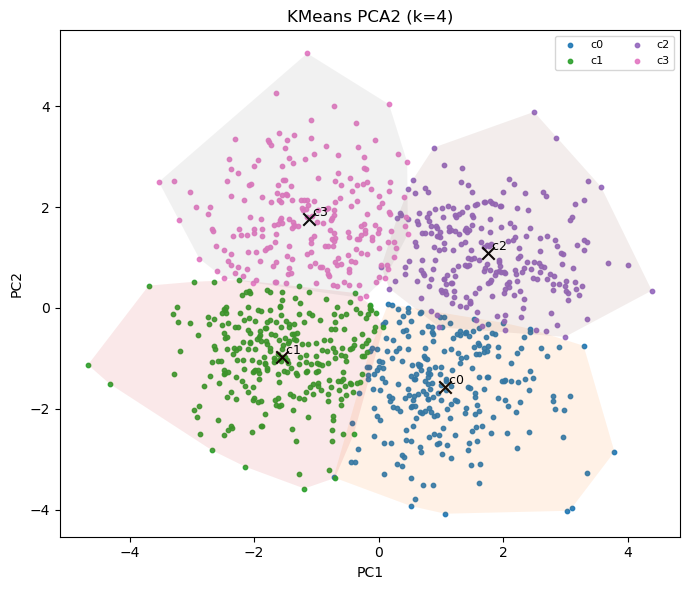

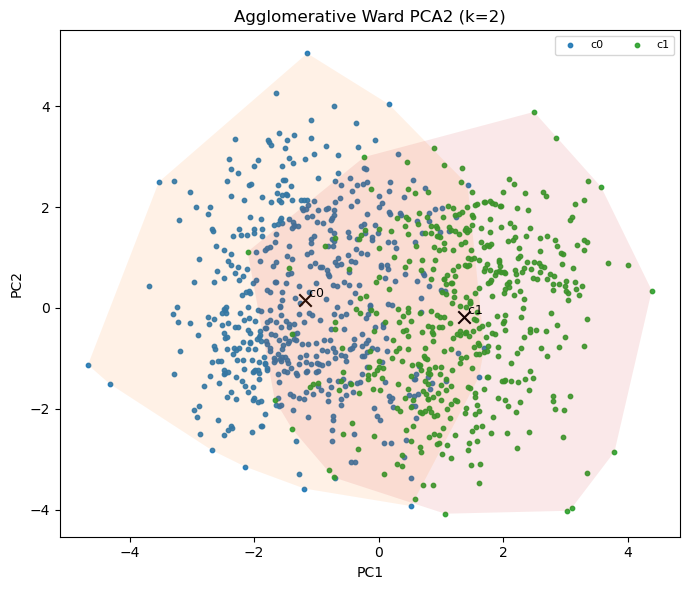

TypeError: iteration over a 0-d array

In [59]:
# Dispersión PCA2 por clusters, con centroides y envolventes (convex hull)
import numpy as np
import matplotlib.pyplot as plt

try:
    from scipy.spatial import ConvexHull
    _HAS_HULL = True
except Exception:
    _HAS_HULL = False

def plot_clusters_2d(X2d, labels, title='Clusters en PCA2', show_centroids=True, show_hull=True):
    labels = np.asarray(labels)
    unique = sorted(list(set(labels)))
    fig, ax = plt.subplots(1,1, figsize=(7,6))

    # Ruido (DBSCAN) en gris
    if np.issubdtype(labels.dtype, np.number) and -1 in unique:
        mask_noise = labels == -1
        ax.scatter(X2d[mask_noise,0], X2d[mask_noise,1], c='lightgray', s=10, alpha=0.6, label='ruido')
        unique = [u for u in unique if u != -1]

    # Colorear clusters restantes
    for c in unique:
        pts = X2d[labels == c]
        ax.scatter(pts[:,0], pts[:,1], s=10, alpha=0.9, label=f'c{c}')
        # Centroides (media en PCA2)
        if show_centroids and pts.shape[0] > 0:
            cent = pts.mean(axis=0)
            ax.scatter(cent[0], cent[1], c='black', s=80, marker='x')
            ax.text(cent[0], cent[1], f' c{c}', color='black', fontsize=9, va='bottom')
        # Envolvente convexa
        if show_hull and _HAS_HULL and pts.shape[0] >= 3:
            try:
                hull = ConvexHull(pts)
                poly = pts[hull.vertices]
                ax.fill(poly[:,0], poly[:,1], alpha=0.1)
            except Exception:
                pass

    ax.set_title(title); ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
    ax.legend(loc='best', fontsize=8, ncol=2)
    plt.tight_layout(); plt.show()

# Ejemplos:
plot_clusters_2d(X_pca2, labels_km_elbow, title=f'KMeans PCA2 (k={len(set(labels_km_elbow))})')
plot_clusters_2d(X_pca2, labels_ag, title=f'Agglomerative Ward PCA2 (k={len(set(labels_ag))})')
plot_clusters_2d(X_pca2, labels_db, title='DBSCAN PCA2')


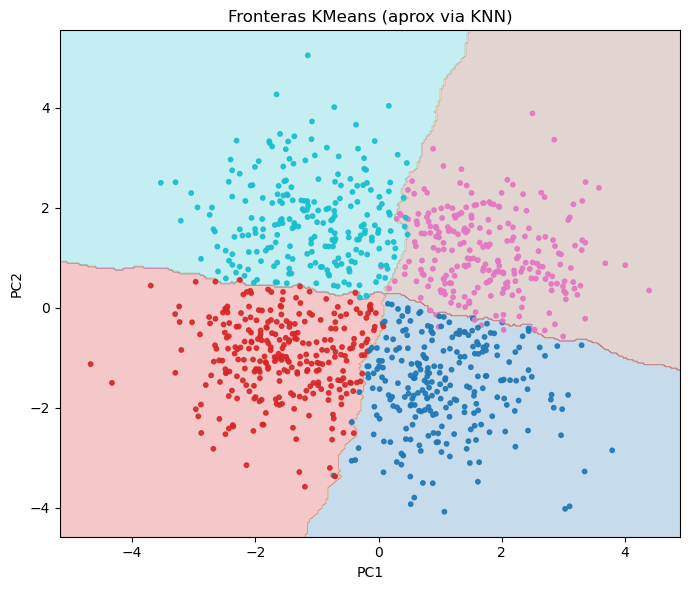

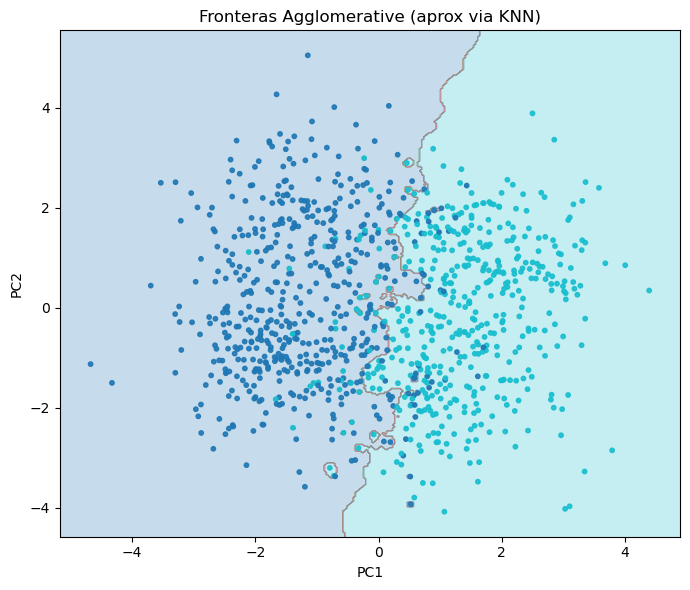

No hay >=2 clusters válidos para fronteras.


In [60]:
# Límites de decisión aproximados en PCA2 usando KNN entrenado sobre las etiquetas dadas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

def plot_decision_boundaries(X2d, labels, title='Fronteras de decisión (KNN sobre PCA2)', n_neighbors=25, grid=300):
    labels = np.asarray(labels)
    # Excluye ruido de DBSCAN para entrenar fronteras
    mask_train = ~(labels == -1)
    if mask_train.sum() < 2 or len(np.unique(labels[mask_train])) < 2:
        print('No hay >=2 clusters válidos para fronteras.')
        return

    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
    knn.fit(X2d[mask_train], labels[mask_train])

    x_min, x_max = X2d[:,0].min() - 0.5, X2d[:,0].max() + 0.5
    y_min, y_max = X2d[:,1].min() - 0.5, X2d[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid),
                         np.linspace(y_min, y_max, grid))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    fig, ax = plt.subplots(1,1,figsize=(7,6))
    ax.contourf(xx, yy, Z, alpha=0.25, cmap='tab10')

    # Puntos: ruido gris, clusters coloreados
    if np.any(labels == -1):
        ax.scatter(X2d[labels==-1,0], X2d[labels==-1,1], c='lightgray', s=10, alpha=0.6, label='ruido')
    ax.scatter(X2d[mask_train,0], X2d[mask_train,1], c=labels[mask_train], s=10, cmap='tab10', alpha=0.9)

    ax.set_title(title); ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
    plt.tight_layout(); plt.show()

# Ejemplos:
plot_decision_boundaries(X_pca2, labels_km_elbow, title='Fronteras KMeans (aprox via KNN)')
plot_decision_boundaries(X_pca2, labels_ag, title='Fronteras Agglomerative (aprox via KNN)')
plot_decision_boundaries(X_pca2, labels_db, title='Fronteras DBSCAN (aprox via KNN, sin ruido)')


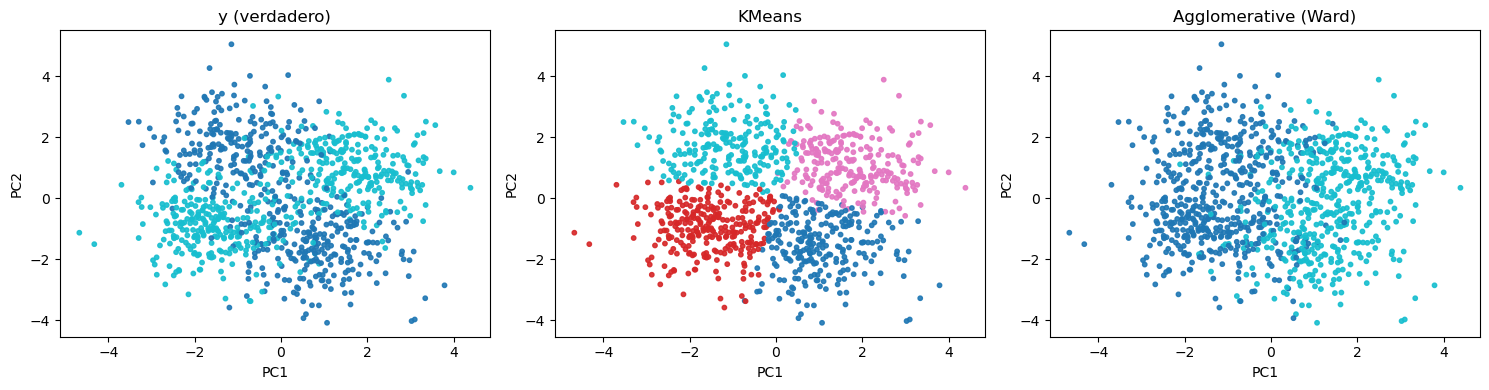

In [62]:
# Panel comparativo: y vs KMeans vs Ward vs DBSCAN
import numpy as np
import matplotlib.pyplot as plt

def scatter_compare_panels(X2d, y_true=None, labels_km=None, labels_ag=None, labels_db=None):
    panels = []
    titles = []
    if y_true is not None:
        panels.append(np.asarray(y_true)); titles.append('y (verdadero)')
    if labels_km is not None:
        panels.append(np.asarray(labels_km)); titles.append('KMeans')
    if labels_ag is not None:
        panels.append(np.asarray(labels_ag)); titles.append('Agglomerative (Ward)')
    if labels_db is not None:
        panels.append(np.asarray(labels_db)); titles.append('DBSCAN')

    if not panels:
        print('No hay datos para mostrar.')
        return

    n = len(panels)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 4))
    axes = axes if isinstance(axes, np.ndarray) else [axes]

    for ax, lab, tit in zip(axes, panels, titles):
        if np.issubdtype(lab.dtype, np.number) and np.any(lab == -1):
            ax.scatter(X2d[lab==-1,0], X2d[lab==-1,1], c='lightgray', s=10, alpha=0.6, label='ruido')
            ax.scatter(X2d[lab!=-1,0], X2d[lab!=-1,1], c=lab[lab!=-1], s=10, cmap='tab10', alpha=0.9)
        else:
            ax.scatter(X2d[:,0], X2d[:,1], c=lab, s=10, cmap='tab10', alpha=0.9)
        ax.set_title(tit); ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
    plt.tight_layout(); plt.show()

# Ejemplo:
scatter_compare_panels(X_pca2, y_true=y_work, labels_km=labels_km_elbow, labels_ag=labels_ag, labels_db=labels_db)


In [63]:
#semisupervisado 

In [64]:
# Semi-supervisado: generar etiquetas parciales (sintéticas)
import numpy as np

def make_partial_labels(y_true, frac_labeled=0.1, per_class=True, random_state=42):
    rng = np.random.RandomState(random_state)
    y_true = np.asarray(y_true)
    n = len(y_true)
    mask = np.zeros(n, dtype=bool)
    if per_class:
        for c in np.unique(y_true):
            idx = np.where(y_true == c)[0]
            k = max(1, int(np.ceil(frac_labeled * len(idx))))
            chosen = rng.choice(idx, size=k, replace=False)
            mask[chosen] = True
    else:
        k = max(1, int(np.ceil(frac_labeled * n)))
        chosen = rng.choice(np.arange(n), size=k, replace=False)
        mask[chosen] = True
    y_semi = np.full(n, -1, dtype=int)
    y_semi[mask] = y_true[mask]
    return y_semi, mask

y_semi, mask_labeled = make_partial_labels(y_work, frac_labeled=0.1, per_class=True, random_state=42)
print("Labeled fraction:", round(mask_labeled.mean(),3), "| classes labeled present:", np.unique(y_semi[mask_labeled]))


Labeled fraction: 0.101 | classes labeled present: [0 1]


In [65]:
# Mapear clusters a clases usando solo las etiquetas conocidas y evaluar en no-etiquetados
import numpy as np
import pandas as pd

def cluster_majority_map(labels, y_semi, mask_labeled):
    labels = np.asarray(labels)
    y_semi = np.asarray(y_semi)
    mapping = {}
    anchored = set()
    for c in np.unique(labels):
        m = (labels == c) & mask_labeled
        if m.sum() == 0:
            continue
        vals, counts = np.unique(y_semi[m], return_counts=True)
        lbl = int(vals[np.argmax(counts)])
        mapping[int(c)] = lbl
        anchored.add(int(c))
    return mapping, anchored

def assign_with_fallback(labels, mapping, X_rep=None):
    labels = np.asarray(labels)
    y_pred = np.full(len(labels), -1, dtype=int)
    # direct mapped clusters
    for c, lbl in mapping.items():
        y_pred[labels == c] = lbl
    # fallback para clusters no anclados: asigna por cluster anclado más cercano (en X_rep)
    if X_rep is not None and np.any(y_pred == -1):
        uniq = np.unique(labels)
        centroids = {int(c): X_rep[labels==c].mean(axis=0) for c in uniq if np.sum(labels==c) > 0}
        anchored = [c for c in uniq if c in mapping]
        if len(anchored) > 0:
            an_cent = np.vstack([centroids[c] for c in anchored])
            an_labels = np.array([mapping[c] for c in anchored])
            for c in uniq:
                if c in mapping or np.sum(labels==c)==0:
                    continue
                ccent = centroids[c]
                d = np.linalg.norm(an_cent - ccent, axis=1)
                y_pred[labels==c] = int(an_labels[np.argmin(d)])
    return y_pred

def semi_sup_eval(labels, y_true, y_semi, mask_labeled, X_rep=None):
    from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score
    mapping, anchored = cluster_majority_map(labels, y_semi, mask_labeled)
    y_pred = assign_with_fallback(labels, mapping, X_rep=X_rep)
    mask_u = ~mask_labeled
    acc_u = accuracy_score(y_true[mask_u], y_pred[mask_u])
    ari_u = adjusted_rand_score(y_true[mask_u], y_pred[mask_u])
    nmi_u = normalized_mutual_info_score(y_true[mask_u], y_pred[mask_u])
    return {'acc_unlabeled':acc_u, 'ARI_unlabeled':ari_u, 'NMI_unlabeled':nmi_u,
            'anchored_clusters':len(anchored), 'mapped_frac':float((y_pred[mask_u]!=-1).mean())}, y_pred, mapping

results_semi = []
if 'labels_km_elbow' in globals():
    r_km, ypred_km, map_km = semi_sup_eval(labels_km_elbow, y_work, y_semi, mask_labeled, X_rep=X_rep_train)
    r_km['model']='KMeans'; results_semi.append(r_km)
    print('KMeans semi-supervisado:', r_km)
if 'labels_ag' in globals():
    r_ag, ypred_ag, map_ag = semi_sup_eval(labels_ag, y_work, y_semi, mask_labeled, X_rep=X_rep_train)
    r_ag['model']='Agglomerative'; results_semi.append(r_ag)
    print('Agglomerative semi-supervisado:', r_ag)
if 'labels_db' in globals() and labels_db is not None:
    r_db, ypred_db, map_db = semi_sup_eval(labels_db, y_work, y_semi, mask_labeled, X_rep=X_rep_train)
    r_db['model']='DBSCAN'; results_semi.append(r_db)
    print('DBSCAN semi-supervisado:', r_db)

if results_semi:
    display(pd.DataFrame(results_semi))


KMeans semi-supervisado: {'acc_unlabeled': 0.8387096774193549, 'ARI_unlabeled': 0.4582917635456285, 'NMI_unlabeled': 0.36157250807049, 'anchored_clusters': 4, 'mapped_frac': 1.0, 'model': 'KMeans'}
Agglomerative semi-supervisado: {'acc_unlabeled': 0.5305895439377085, 'ARI_unlabeled': 0.0, 'NMI_unlabeled': 0.0, 'anchored_clusters': 2, 'mapped_frac': 1.0, 'model': 'Agglomerative'}


,acc_unlabeled,ARI_unlabeled,NMI_unlabeled,anchored_clusters,mapped_frac,model
0,0.83871,0.458292,0.361573,4,1.0,KMeans
1,0.53059,0.000000,0.000000,2,1.0,Agglomerative


In [66]:
# Baseline semi-supervisado con LabelSpreading
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score

ls = LabelSpreading(kernel='rbf', gamma=0.5, max_iter=50, alpha=0.2)
ls.fit(X_rep_train, y_semi)
yp_ls = ls.predict(X_rep_train)

mask_u = ~mask_labeled
acc_u = accuracy_score(y_work[mask_u], yp_ls[mask_u])
ari_u = adjusted_rand_score(y_work[mask_u], yp_ls[mask_u])
nmi_u = normalized_mutual_info_score(y_work[mask_u], yp_ls[mask_u])
print(f'LabelSpreading (unlabeled) acc={acc_u:.3f} ARI={ari_u:.3f} NMI={nmi_u:.3f}')


LabelSpreading (unlabeled) acc=0.719 ARI=0.190 NMI=0.141


In [67]:
# KMeans con 'semillas' de clases: centros iniciales = medias de X_rep_train de los puntos etiquetados
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score

classes_l = np.unique(y_semi[mask_labeled])
k_seed = len(classes_l)
centers_seed = []
for c in classes_l:
    centers_seed.append(X_rep_train[(y_semi==c) & mask_labeled].mean(axis=0))
centers_seed = np.vstack(centers_seed)

km_seed = KMeans(n_clusters=k_seed, init=centers_seed, n_init=1, random_state=42)
labels_seed = km_seed.fit_predict(X_rep_train)

# Mapping cluster->clase por mayoría sobre etiquetas conocidas, por robustez
map_major, _ = cluster_majority_map(labels_seed, y_semi, mask_labeled)
y_pred_seed = assign_with_fallback(labels_seed, map_major, X_rep=X_rep_train)

mask_u = ~mask_labeled
acc_u = accuracy_score(y_work[mask_u], y_pred_seed[mask_u])
ari_u = adjusted_rand_score(y_work[mask_u], y_pred_seed[mask_u])
nmi_u = normalized_mutual_info_score(y_work[mask_u], y_pred_seed[mask_u])
print(f'Seeded KMeans (unlabeled) acc={acc_u:.3f} ARI={ari_u:.3f} NMI={nmi_u:.3f}')


Seeded KMeans (unlabeled) acc=0.474 ARI=0.002 NMI=0.002


In [68]:
# Constraints ML/CL a partir de etiquetas conocidas y % de satisfacción por clustering
import numpy as np
import pandas as pd

def sample_constraints(y_true, mask_labeled, n_pairs=1000, random_state=42):
    rng = np.random.RandomState(random_state)
    idx_l = np.where(mask_labeled)[0]
    if len(idx_l) < 2:
        return [], []
    # Must-link: pares del mismo label entre etiquetados
    ML = []
    for c in np.unique(y_true[idx_l]):
        arr = np.where(mask_labeled & (y_true==c))[0]
        if len(arr) >= 2:
            a = rng.choice(arr, size=min(len(arr), n_pairs//4), replace=False)
            b = rng.choice(arr, size=len(a), replace=False)
            ML += list(zip(a, b))
    # Cannot-link: pares de distintas clases entre etiquetados
    CL = []
    tries = 0
    while len(CL) < n_pairs//2 and tries < n_pairs*5:
        i, j = rng.choice(idx_l, size=2, replace=False)
        if y_true[i] != y_true[j]:
            CL.append((i, j))
        tries += 1
    return ML[:n_pairs//2], CL[:n_pairs//2]

def constraint_satisfaction(labels, ML, CL):
    labels = np.asarray(labels)
    sat_ml = np.mean([labels[i]==labels[j] for (i,j) in ML]) if ML else np.nan
    sat_cl = np.mean([labels[i]!=labels[j] for (i,j) in CL]) if CL else np.nan
    return sat_ml, sat_cl

ML, CL = sample_constraints(y_work, mask_labeled, n_pairs=1000, random_state=42)
rows = []
if 'labels_km_elbow' in globals():
    s_ml, s_cl = constraint_satisfaction(labels_km_elbow, ML, CL); rows.append({'model':'KMeans','ML':s_ml,'CL':s_cl})
if 'labels_ag' in globals():
    s_ml, s_cl = constraint_satisfaction(labels_ag, ML, CL); rows.append({'model':'Agglomerative','ML':s_ml,'CL':s_cl})
if 'labels_db' in globals() and labels_db is not None:
    s_ml, s_cl = constraint_satisfaction(labels_db, ML, CL); rows.append({'model':'DBSCAN','ML':s_ml,'CL':s_cl})
if 'labels_seed' in globals():
    s_ml, s_cl = constraint_satisfaction(labels_seed, ML, CL); rows.append({'model':'KMeans_seeded','ML':s_ml,'CL':s_cl})
display(pd.DataFrame(rows))


,model,ML,CL
0,KMeans,0.376238,0.880
1,Agglomerative,0.524752,0.514
2,KMeans_seeded,0.485149,0.508


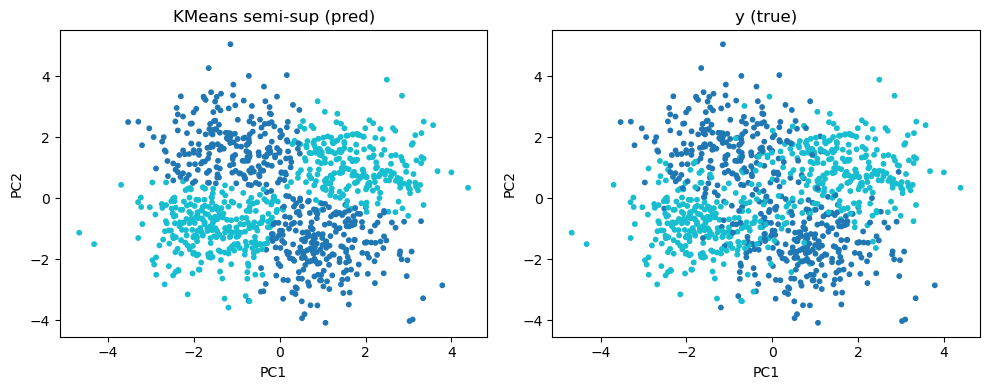

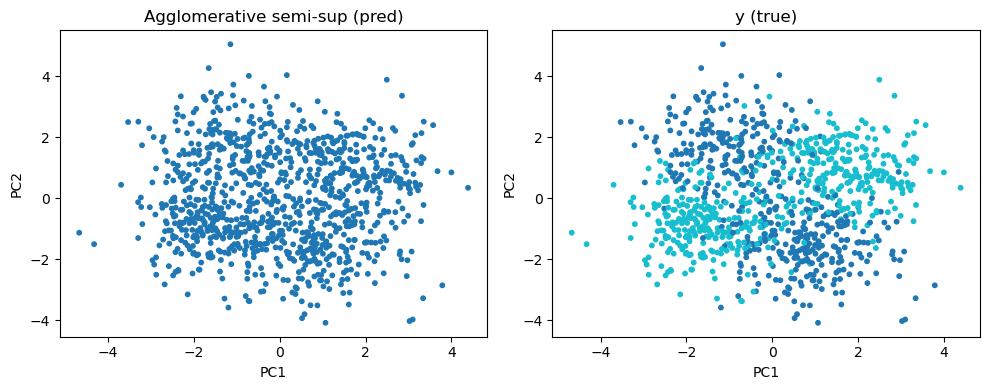

In [70]:
# Dispersión PCA2 coloreada por predicciones semi-supervisadas (KMeans/AGG/DBSCAN) frente a y_work
import matplotlib.pyplot as plt
import numpy as np

def quick_scatter_two(X2d, c1, c2, t1='Semi-sup pred', t2='y (true)'):
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].scatter(X2d[:,0], X2d[:,1], c=c1, s=10, cmap='tab10')
    ax[0].set_title(t1); ax[0].set_xlabel('PC1'); ax[0].set_ylabel('PC2')
    ax[1].scatter(X2d[:,0], X2d[:,1], c=c2, s=10, cmap='tab10')
    ax[1].set_title(t2); ax[1].set_xlabel('PC1'); ax[1].set_ylabel('PC2')
    plt.tight_layout(); plt.show()

# Ejemplos (descomenta según tengas disponibles):
quick_scatter_two(X_pca2, ypred_km, y_work, t1='KMeans semi-sup (pred)', t2='y (true)')
quick_scatter_two(X_pca2, ypred_ag, y_work, t1='Agglomerative semi-sup (pred)', t2='y (true)')
if 'ypred_db' in globals(): quick_scatter_two(X_pca2, ypred_db, y_work, t1='DBSCAN semi-sup (pred)', t2='y (true)')


In [3]:
df_train = pd.DataFrame(X_train)
df_train["y"] = y_train

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1000 non-null   float32
 1   1       1000 non-null   float32
 2   2       1000 non-null   float32
 3   3       1000 non-null   float32
 4   4       1000 non-null   float32
 5   5       1000 non-null   float32
 6   6       1000 non-null   float32
 7   7       1000 non-null   float32
 8   8       1000 non-null   float32
 9   9       1000 non-null   float32
 10  10      1000 non-null   float32
 11  11      1000 non-null   float32
 12  12      1000 non-null   float32
 13  13      1000 non-null   float32
 14  14      1000 non-null   float32
 15  15      1000 non-null   float32
 16  16      1000 non-null   float32
 17  17      1000 non-null   float32
 18  18      1000 non-null   float32
 19  19      1000 non-null   float32
 20  y       1000 non-null   int64  
dtypes: float32(20), int64(1)
memory usage:

In [5]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1000.0,0.023801,1.089761,-3.789389,-0.721965,0.027162,0.755513,3.421769
1,1000.0,0.051353,1.080855,-3.275002,-0.655450,0.041898,0.784048,4.189188
2,1000.0,-0.016699,1.079677,-3.673204,-0.787843,0.010982,0.730634,3.115408
3,1000.0,0.020372,1.100977,-3.346933,-0.772707,0.001392,0.784678,3.513436
4,1000.0,0.027876,1.104239,-2.934976,-0.708734,0.021660,0.779033,4.258661
5,1000.0,0.040844,1.076074,-2.966682,-0.735771,0.065818,0.757994,3.112791
6,1000.0,0.020126,1.117848,-3.216156,-0.768629,-0.013546,0.790539,3.563128
7,1000.0,0.009970,1.112152,-3.225683,-0.749929,-0.018637,0.793928,3.234170
8,1000.0,0.001265,1.094216,-3.341144,-0.703068,0.007781,0.763059,3.809522
9,1000.0,-0.036803,1.067097,-3.857510,-0.742587,-0.007605,0.680511,3.245105


In [6]:
df_train["y"].value_counts()

y
 1    531
-1    469
Name: count, dtype: int64

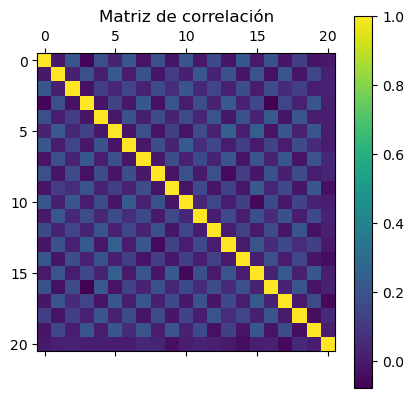

In [7]:
corr = df_train.corr(numeric_only=True)

plt.matshow(corr)
plt.title("Matriz de correlación")
plt.colorbar()
plt.show()

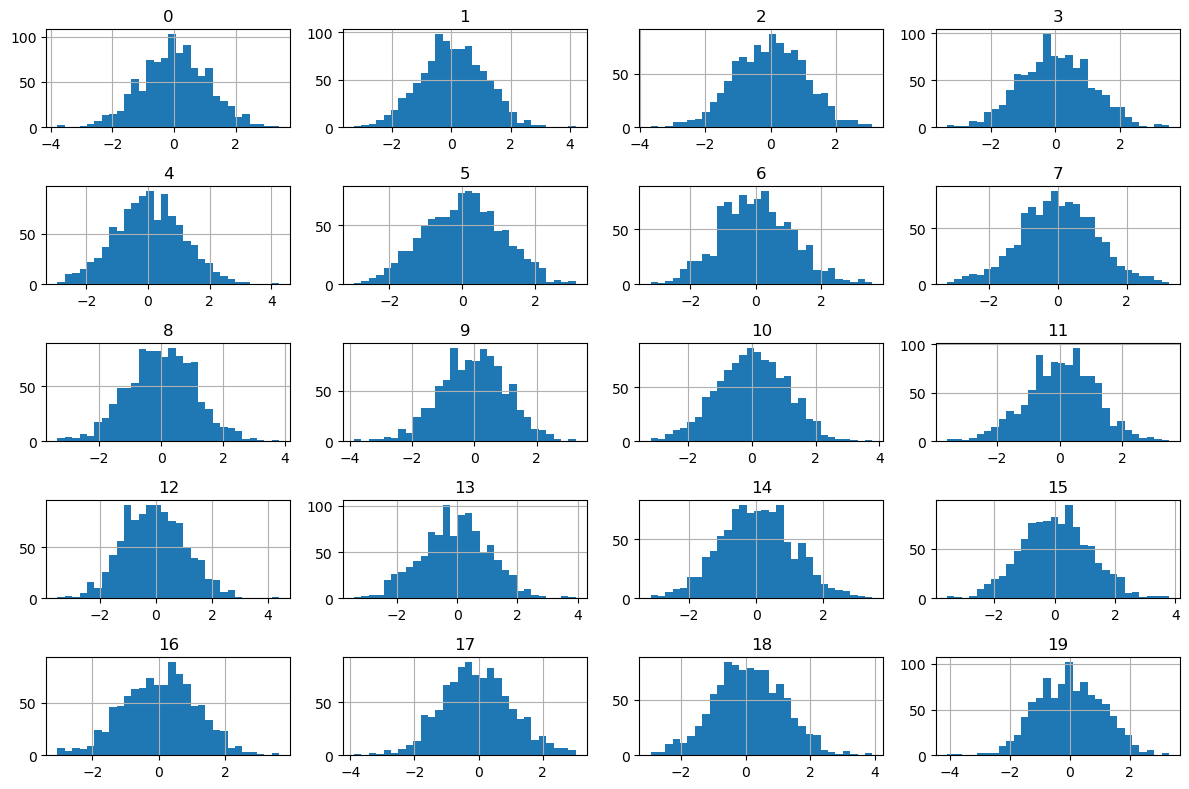

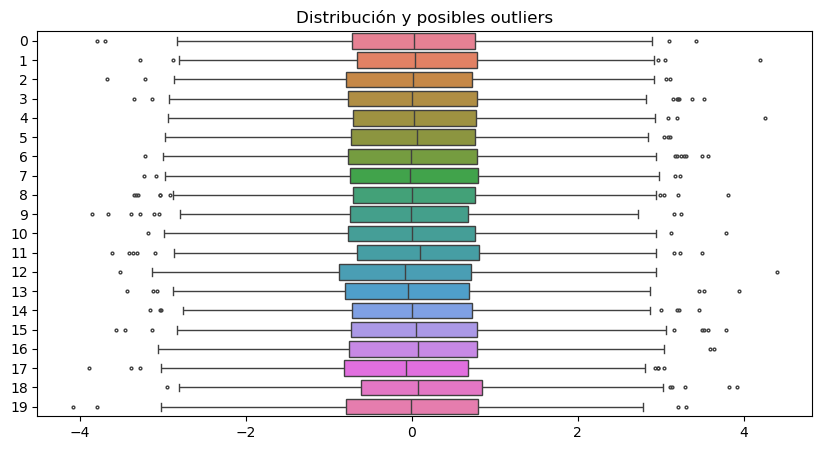

In [8]:
df_features = df_train.drop(columns="y")

# Histograma conjunto
df_features.hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

# Boxplots globales
plt.figure(figsize=(10,5))
sns.boxplot(data=df_features, orient="h", fliersize=2)
plt.title("Distribución y posibles outliers")
plt.show()

In [9]:
#importantisimo normalizar datos!!
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

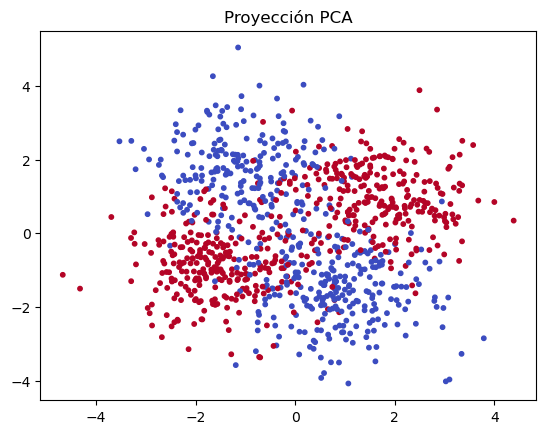

In [15]:
#Reducción de dimensionalidad, explicar porque se deben reducir caracteristicas (columnas del dataset)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=y_train, cmap="coolwarm", s=10)
plt.title("Proyección PCA")
plt.show()

In [11]:
#sns.pairplot(df_train.sample(200), hue="y", diag_kind="kde", plot_kws={'s':10})
#plt.show()

In [12]:
#considerar eliminacion de outliers? 
